# Sprint 機械学習スクラッチ SVM

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 評価
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# 可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [2]:
# データ
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

# trainとtestに分ける
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [3]:
X_train.shape

(375, 2)

# 【問題1】ラグランジュの未定乗数法による最急降下
### １．カーネル関数

In [4]:
# カーネル関数
def kernel(X,i,j):
    k = np.dot(X[i].T,X[j])
    return k

### ２．最急降下法

In [5]:
# 仮のパラメータ
# lamdaの初期値
lamda = np.ones(len(X))
# 学習率
lr = 0.001
# イテレーション
iter = 3

# ラグランジェ乗数　最急降下法
# イテレーション回数分回す．
for num in range(iter):
    # イテレーションごとにλを初期化
    lamda_old = np.zeros(lamda.shape)
    for i in range(len(X)):
        # 更新ごとにsigma内を初期化
        sigma = 0
        for j in range(len(X)):
            sigma += lamda[j]*y[i]*y[j]*kernel(X,i,j)
        
        lamda_old[i] = lamda[i] + lr*(1-sigma)
        # λが０以下なら0にする
        if lamda_old[i] < 0:
            lamda_old[i] = 0
    
    
    # 初期化前に求めたλをコピーしとく
    lamda = lamda_old.copy()

# 【問題2】サポートベクターの決定
#### メモ：np.where
np.where(X < 0.5, 0, 1))・・・Xが0.5以下なら０，以上なら１                                
np.where(lamda > 0.5)・・・・lamdaが0.5以下のインデックスを取得

In [6]:
# 閾値
threshold = 1e-3

# サポートベクターのインデックスを取得
sv_index = np.where(lamda > threshold)

# sv_indexの特徴量
sv = X[sv_index]
# sv_indexのラグランジュ乗数
lamda_sv = lamda[sv_index]
# sv_indexのｙ
y_sv = y[sv_index]


print('サポートベクターの数：',sv.shape[0])
print('sv_shape:',sv.shape)
print('lamda_sv_shape:',lamda_sv.shape)
print('y_sv_shape:',y_sv.shape)
print('X_shape:',X.shape)
print('\nSV_index:\n',sv_index)
print('\nサポートベクター:\n',sv)

サポートベクターの数： 4
sv_shape: (4, 2)
lamda_sv_shape: (4,)
y_sv_shape: (4,)
X_shape: (500, 2)

SV_index:
 (array([121, 123, 162, 326], dtype=int64),)

サポートベクター:
 [[-1.02829008  0.23898594]
 [-0.97854994  0.34188908]
 [-0.50179779  0.74466058]
 [ 0.67098941 -0.58384118]]


# 【問題3】推定
メモ：np.sign()・・・各要素について，正の場合1，負の場合-1，0の場合は0を返す

In [7]:
def predict(X):
    y_pred = [np.sum([lamda_j * y_j * np.dot(x_j, x)
                      for (x_j, y_j, lamda_j) in zip(
                        sv, y_sv, lamda_sv)])
                   for x in X]
    return np.array(np.sign(y_pred))

# 【問題4】学習と推定
## １．スクラッチSVM

In [9]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """

    def __init__(self, num_iter, lr, threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        #self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
    
    
    # カーネル関数
    def _kernel(self,X,i,j):
        k = np.dot(X[i].T,X[j])
        return k
    
    # ラグランジェ乗数　最急降下法
    def _gradient_descent(self,X,y,lamda):
        lamda_old = np.zeros(lamda.shape)
        for i in range(len(X)):
            sigma = 0
            for j in range(len(X)):
                sigma += lamda[j]*y[i]*y[j]*self._kernel(X,i,j)
            lamda_old[i] = lamda[i] + self.lr*(1-sigma)
            if lamda_old[i] < 0:
                lamda_old[i] = 0
        lamda = lamda_old.copy()
        return lamda
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        # λの初期化
        lamda = np.zeros(len(X))
        # イテレーションの数だけ学習
        for num in range(self.iter):
            lamda = self._gradient_descent(X,y,lamda)

            # 学習過程の出力
            if self.verbose is True:
                map_result_lamda = map(str, lamda)
                result_lamda = ',\n'.join(map_result_lamda)
                print('\nTrain Data λ学習{0}回目 : \n{1}'.format(num,result_lamda))
            else:
                pass
        
        self.index_support_vectors = np.where(lamda > self.threshold)
        self.X_sv = X[self.index_support_vectors]
        self.n_support_vectors = self.X_sv.shape[0]
        self.lam_sv = lamda[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        
        
        # テストデータがある場合
        if X_val is not None:
            #カーネル関数が線形なら
            #if self.kernel == linear:
            # λの初期化
            lamda_val = np.zeros(len(X_val))
            # イテレーションの数だけ学習
            for num in range(self.iter):
                lamda_val =  self._gradient_descent(X_val,y_val,lamda_val)
                
                # 学習過程の出力
                if self.verbose is True:
                    map_result_lamda_val = map(str, lamda_val)
                    result_lamda_val = ',\n'.join(map_result_lamda_val)
                    print('\nTest Data λ 学習{0}回目 : \n{1}'.format(num,result_lamda_val))
                else:
                    pass

            # サポートベクター
            self.index_support_vectors_val = np.where(lamda_val > self.threshold)
            self.X_sv_val = X_val[self.index_support_vectors_val]
            self.lam_sv_val = lamda_val[self.index_support_vectors_val]
            self.y_sv_val = y_val[self.index_support_vectors_val]
    
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        step1 = X@self.X_sv.T
        y_pred = (self.lam_sv*self.y_sv)@step1.T
        return np.sign(y_pred)

In [10]:
# 初期化，学習，推定
scratch_svm = ScratchSVMClassifier(num_iter=1000, lr=0.001, threshold=1e-5, verbose=False)
scratch_svm.fit(X_train,y_train)
y_pred = scratch_svm.predict(X_test)

In [11]:
# Accuracy，Precision，Recall，f1
print('Accuracy:',accuracy_score(y_test, y_pred))
print('\n',classification_report(y_test,y_pred))
print('サポートベクターの数:',scratch_svm.n_support_vectors)

Accuracy: 1.0

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        74

   micro avg       1.00      1.00      1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

サポートベクターの数: 8


## ２．sklearn

In [12]:
from sklearn import svm
# 初期化，学習，推定
clf = svm.SVC(C=1.0, kernel='linear')
clf.fit(X_train, y_train)
y_pred_sk = clf.predict(X_test)

# Accuracy，Precision，Recall，f1
print('Accuracy:',accuracy_score(y_test, y_pred_sk))
print('\n',classification_report(y_test,y_pred_sk))

Accuracy: 1.0

               precision    recall  f1-score   support

          -1       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        74

   micro avg       1.00      1.00      1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125



# 【問題5】決定領域の可視化

In [13]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='Decision Region', xlabel='f0', ylabel='f1', target_names=['1', '-1']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    
    plt.scatter(model.X_sv[:,0], model.X_sv[:,1], s=80, color='y',marker='^',label='SV')
    
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

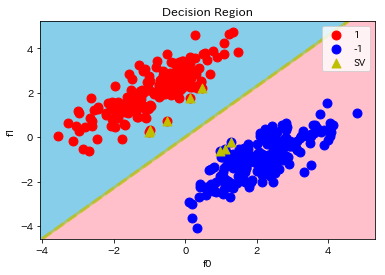

In [14]:
decision_region(X=X_train, y=y_train, model=scratch_svm, step=0.01, title='Decision Region', xlabel='f0', ylabel='f1', target_names=['1', '-1'])

# 【問題6】（アドバンス課題）多項式カーネル関数の作成
 ### sklearn SVM 'poly'のハイパーパラメータ
  #### gamma ： float（デフォルト= 'auto'）
   * 「rbf」、「poly」、および「sigmoid」のカーネル係数。
   * 現在のデフォルトは1 / n_featuresを使用する 'auto'
   * gamma='scale'渡された場合、1 /（n_features * X.var（））
   * 現在のgammaのデフォルト「auto」は、バージョン0.22で「scale」に変更される．
#### coef0 ： float（デフォルト= 0.0）
   θ0のこと
#### degree ： int（デフォルト= 3）
   多項式カーネル関数の次数

In [15]:
# パラメータを設定
gamma = 1/len(X)
theta = 0.1
degree = 3

def _poly(X,i,j):
    k = gamma*(X[i]@X[j] + theta)**degree
    return k

In [16]:
_poly(X,1,2)

0.019741768196832637

In [17]:
class ScratchSVMClassifier_poly():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（poly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False,gamma=0.02,theta=0.1,degree=3):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        self.theta = theta
        self.degree = degree
    
    
    # 線形カーネル
    def _linear(self,X,i,j):
        k = np.dot(X[i].T,X[j])
        return k
    
    
    # 多項式カーネル
    def _poly(self,X,i,j):
        k = self.gamma*(X[i]@X[j] + self.theta)**self.degree
        return k

    
    # ラグランジェ乗数　最急降下法
    def _gradient_descent(self,X,y,lamda):
        lamda_old = np.zeros(lamda.shape)
        for i in range(len(X)):
            sigma = 0
            for j in range(len(X)):
                sigma += lamda[j]*y[i]*y[j]*self._kernel_function(X,i,j)
            lamda_old[i] = lamda[i] + self.lr*(1-sigma)
            if lamda_old[i] < 0:
                lamda_old[i] = 0
        lamda = lamda_old.copy()
        return lamda
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        if self.kernel == 'linear':
            self._kernel_function = self._linear
        elif self.kernel == 'poly':
            self._kernel_function = self._poly
        else:
            print('カーネル関数が正しくありません．')

        # λの初期化
        lamda = np.zeros(len(X))
        # イテレーションの数だけ学習
        for num in range(self.iter):
            lamda = self._gradient_descent(X,y,lamda)

            # 学習過程の出力
            if self.verbose is True:
                map_result_lamda = map(str, lamda)
                result_lamda = ',\n'.join(map_result_lamda)
                print('\nTrain Data λ学習{0}回目 : \n{1}'.format(num,result_lamda))
            else:
                pass
        
        # サポートベクター
        self.index_support_vectors = np.where(lamda > self.threshold)
        self.X_sv = X[self.index_support_vectors]
        self.n_support_vectors = self.X_sv.shape[0]
        self.lam_sv = lamda[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]
        
        
        # テストデータがある場合
        if X_val is not None:
            #カーネル関数が線形なら
            #if self.kernel == linear:
            # λの初期化
            lamda_val = np.zeros(len(X_val))
            # イテレーションの数だけ学習
            for num in range(self.iter):
                lamda_val =  self._gradient_descent(X_val,y_val,lamda_val)
                
                # 学習過程の出力
                if self.verbose is True:
                    map_result_lamda_val = map(str, lamda_val)
                    result_lamda_val = ',\n'.join(map_result_lamda_val)
                    print('\nTest Data λ 学習{0}回目 : \n{1}'.format(num,result_lamda_val))
                else:
                    pass

            # サポートベクター
            self.index_support_vectors_val = np.where(lamda_val > self.threshold)
            self.X_sv_val = X_val[self.index_support_vectors_val]
            self.lam_sv_val = lamda_val[self.index_support_vectors_val]
            self.y_sv_val = y_val[self.index_support_vectors_val]
    
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        step1 = X@self.X_sv.T
        y_pred = (self.lam_sv*self.y_sv)@step1.T
        return np.sign(y_pred)

In [18]:
# 初期化，学習，推定
scratch_svm_poly = ScratchSVMClassifier_poly(num_iter=1000, lr=0.001, kernel='poly', threshold=1e-5, verbose=False,gamma=0.02,theta=0.1,degree=3)
scratch_svm_poly.fit(X_train,y_train,X_test,y_test)
y_pred_poly = scratch_svm_poly.predict(X_test)

In [22]:
print('サポートベクターの数：',scratch_svm_poly.n_support_vectors)

サポートベクターの数： 26


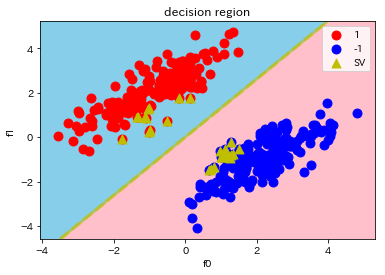

In [20]:
decision_region(X=X_train, y=y_train, model=scratch_svm_poly, step=0.01, title='decision region', xlabel='f0', ylabel='f1', target_names=['1', '-1'])